# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
from skimage.segmentation import slic, join_segmentations, watershed
from skimage.measure import label
from skimage.color import label2rgb
from skimage import exposure
import sys
import numpy as np

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

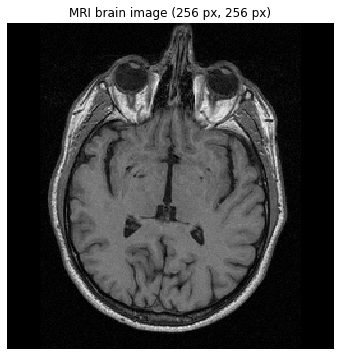

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

In [3]:
def edge_detection(image, index):
    im_h, im_w = image.shape
    
    h1=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    h2=np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    h3=-h1
    h4=-h2
    h5=np.array([[],[],[]])
    h6=np.array([[],[],[]])
    
    edge1 = np.zeros((im_h,im_w))
    edge2 = np.zeros((im_h,im_w))
    edge3 = np.zeros((im_h,im_w))
    edge4 = np.zeros((im_h,im_w))
    
    for i in range (1,im_h - 1):
        for j in range (1,im_w - 1):
            small_img = np.array([[image[i-1][j-1], image[i-1][j], image[i-1][j+1]],
                                  [image[i][j-1], image[i][j], image[i][j+1]],
                                  [image[i+1][j-1], image[i+1][j], image[i+1][j+1]]])
            edge1[i][j] = np.sum(np.multiply(small_img,h1))
            edge2[i][j] = np.sum(np.multiply(small_img,h2))
            edge3[i][j] = np.sum(np.multiply(small_img,h3))
            edge4[i][j] = np.sum(np.multiply(small_img,h4))
            
    edge1 = np.abs(edge1)
    edge2 = np.abs(edge2)
    edge3 = np.abs(edge3)
    edge4 = np.abs(edge4)
    
    edge = edge1 + edge2 + edge3 + edge4
    edge = edge/4
    mask = edge[:,:] < 30
    
    labelled = label(mask)
    
    edge[mask] = 0
    edge[np.logical_not(mask)] = 255
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5),
                         sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    
    ax[1].imshow(edge, cmap='gray')
    ax[1].set_title('edges')
    
    ax[2].imshow(labelled, cmap='hsv')
    ax[2].plot([80], [157], marker='x')
    ax[2].set_title('Labels')
    
    
    for a in ax:
        a.axis('off')
    fig.tight_layout()
    
    brain = np.zeros((im_h,im_w))
    mask = labelled[:,:] == index
    brain[mask] = 255
    brain[np.logical_not(mask)] = 0    
    
    ax[3].imshow(brain, cmap='gray')
    ax[3].set_title('Brain')
    
    plt.show()
    
    return np.sum(brain)/255

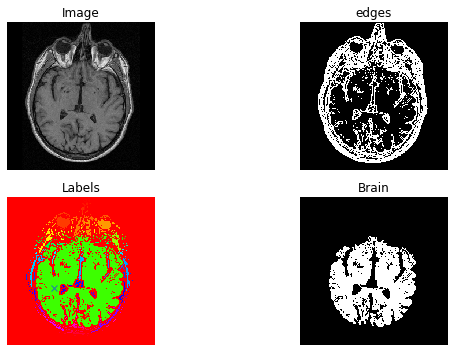

Brain size(pixels) :  13814.0


In [4]:
index = 153
brain_size = edge_detection(brain_im, index)
print("Brain size(pixels) : ", brain_size)

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [5]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


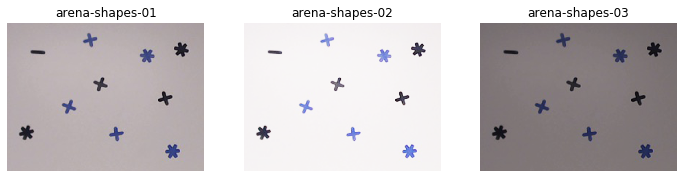

In [6]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

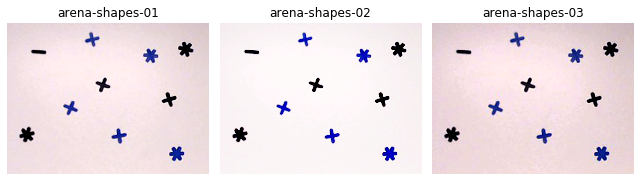

In [7]:
# Contrast stretching
p2, p98 = np.percentile(images[0], (1, 98))
p21, p981 = np.percentile(images[1], (2, 98))
p22, p982 = np.percentile(images[2], (1, 98))

newim1 = exposure.rescale_intensity(images[0], in_range=(p2, p98))
newim2 = exposure.rescale_intensity(images[1], in_range=(p21, p981))
newim3 = exposure.rescale_intensity(images[2], in_range=(p22, p982))

#contains the new images. dimenstions[3 480 640 3]
new_images = np.array([newim1, newim2, newim3])

# Display images
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(9, 5),
                     sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(newim1, cmap='gray')
ax[0].set_title('arena-shapes-01')

ax[1].imshow(newim2, cmap='gray')
ax[1].set_title('arena-shapes-02')

ax[2].imshow(newim3, cmap='gray')
ax[2].set_title('arena-shapes-03')

for a in ax:
    a.axis('off')
fig.tight_layout()


plt.show()


In [8]:
def get_shapes(image):

#///
    #bin_img_arr = morphology.remove_small_objects(bin_img_arr, min_size=7999, connectivity=2)

    contours = measure.find_contours(image, 100)

    labels=measure.label(image,connectivity=2)
    dst=color.label2rgb(labels)
    # print('regions number:',labels.max()+1)

    #fig, (ax0, ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12))
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 24))
    ax0.imshow(image, plt.cm.gray)
    ax1.imshow(image, plt.cm.gray)
    
    #list with coordinates of the center of each shape
    list_centers = np.zeros((len(contours),2))
    
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
        list_centers[n][0] = np.mean(contours[n][:,0])
        list_centers[n][1] = np.mean(contours[n][:,1])
        
        
    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    
    contours = np.array(contours)
    
    for i in range (0,len(list_centers)):
        ax1.plot([np.mean(contours[i][:,1])], [np.mean(contours[i][:,0])], marker='x')
    
    print("marker :", np.mean(contours[2][:,0]), np.mean(contours[2][:,1]))
    print("number of shapes : ", len(contours))
    plt.show() 
     
    
    #need to round list_centers to have coordinates of pixels.
    return np.round(list_centers)

marker : 106.20726399553035 454.7916284917914
number of shapes :  10


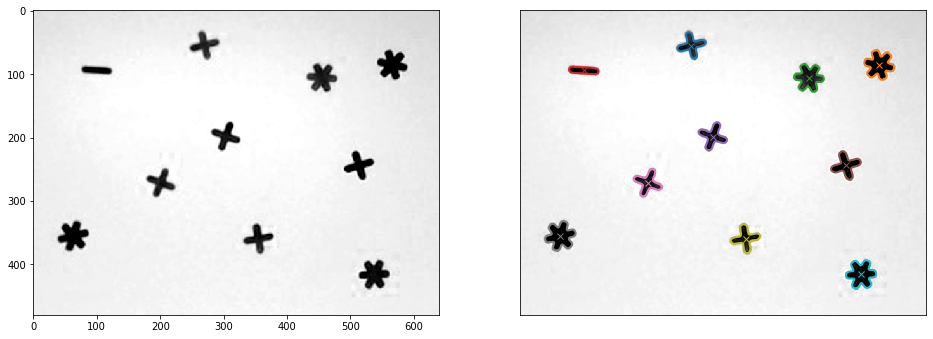

marker : 105.96805020033162 455.2793721678065
number of shapes :  10


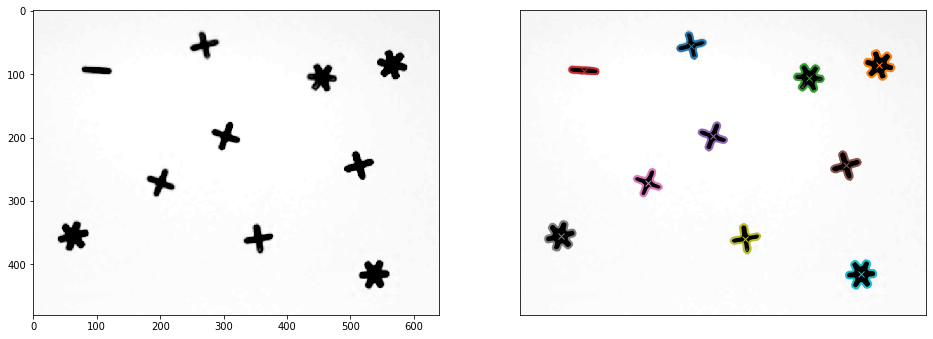

marker : 106.21199592295429 455.0154222481321
number of shapes :  10


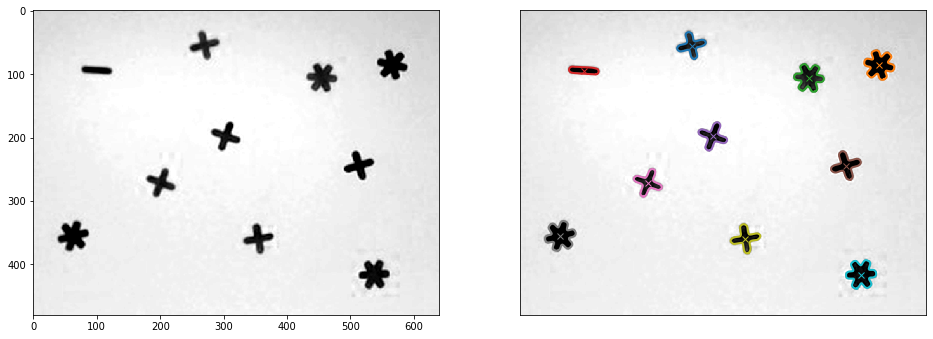

In [9]:
from skimage import morphology, measure, color

list_centers1 = get_shapes(new_images[0,:,:,0])
list_centers2 = get_shapes(new_images[1,:,:,0])
list_centers3 = get_shapes(new_images[2,:,:,0])

list_centers = np.array([list_centers1, list_centers2, list_centers3])

In [13]:
blue_shapes = np.zeros(3)
black_shapes = np.zeros(3)

for i in range (0, len(list_centers)):
    for j in range (0,len(list_centers[0])):
        if new_images[i, int(list_centers[i,j,0]), int(list_centers[i,j,1]), 2] > 100:
            blue_shapes[i] += 1
        else :
            black_shapes[i] += 1
    print("\nImage", i, ": Blue shapes :", blue_shapes[i], ", Black shapes :", black_shapes[i])


Image 0 : Blue shapes : 5.0 , Black shapes : 5.0

Image 1 : Blue shapes : 5.0 , Black shapes : 5.0

Image 2 : Blue shapes : 5.0 , Black shapes : 5.0


In [25]:
import numpy.linalg as lin

def edge_detection_RGB(image, index):
    im_h, im_w,_ = image.shape
    
    h1=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    h2=np.transpose(h1)
    h3=-h1
    h4=-h2
    h5 = np.array([[0,1,1],[-1,0,1],[-1,-1,0]])
    h6 = np.transpose(h5)
    h7 = -h5
    h8 = -h6
    
    edge1 = np.zeros((im_h,im_w))
    edge2 = np.zeros((im_h,im_w))
    edge3 = np.zeros((im_h,im_w))
    edge4 = np.zeros((im_h,im_w))
    edge5 = np.zeros((im_h,im_w))
    edge6 = np.zeros((im_h,im_w))
    edge7 = np.zeros((im_h,im_w))
    edge8 = np.zeros((im_h,im_w))
    
    #lin.norm(np.subtract(b,a), 2, None, False)
    
    
    for i in range (1,im_h - 1):
        for j in range (1,im_w - 1):
            small_img = np.array([[image[i-1][j-1], image[i-1][j], image[i-1][j+1]],
                                  [image[i][j-1], image[i][j], image[i][j+1]],
                                  [image[i+1][j-1], image[i+1][j], image[i+1][j+1]]])
            edge1[i][j] = np.mean((np.sum(np.multiply(small_img[0],h1)), np.sum(np.multiply(small_img[1],h1)), 
                                   np.sum(np.multiply(small_img[2],h1))))
            edge2[i][j] = np.mean((np.sum(np.multiply(small_img[0],h2)), np.sum(np.multiply(small_img[1],h2)), 
                                   np.sum(np.multiply(small_img[2],h2))))
            edge3[i][j] = np.mean((np.sum(np.multiply(small_img[0],h3)), np.sum(np.multiply(small_img[1],h3)), 
                                   np.sum(np.multiply(small_img[2],h3))))
            edge4[i][j] = np.mean((np.sum(np.multiply(small_img[0],h4)), np.sum(np.multiply(small_img[1],h4)), 
                                   np.sum(np.multiply(small_img[2],h4))))
            edge5[i][j] = np.mean((np.sum(np.multiply(small_img[0],h5)), np.sum(np.multiply(small_img[1],h5)), 
                                   np.sum(np.multiply(small_img[2],h5))))
            edge6[i][j] = np.mean((np.sum(np.multiply(small_img[0],h6)), np.sum(np.multiply(small_img[1],h6)), 
                                   np.sum(np.multiply(small_img[2],h6))))
            edge7[i][j] = np.mean((np.sum(np.multiply(small_img[0],h7)), np.sum(np.multiply(small_img[1],h7)), 
                                   np.sum(np.multiply(small_img[2],h7))))
            edge8[i][j] = np.mean((np.sum(np.multiply(small_img[0],h8)), np.sum(np.multiply(small_img[1],h8)), 
                                   np.sum(np.multiply(small_img[2],h8))))
                    
    edge1 = np.abs(edge1)
    edge2 = np.abs(edge2)
    edge3 = np.abs(edge3)
    edge4 = np.abs(edge4)
    edge5 = np.abs(edge5)
    edge6 = np.abs(edge6)
    edge7 = np.abs(edge7)
    edge8 = np.abs(edge8)
    
    edge = (edge1 + edge2 + edge3 + edge4 + edge5 + edge6 + edge7 + edge8)/8
    mask = edge[:,:] < 50
    
    labelled = label(mask)
    
    edge[mask] = 0
    edge[np.logical_not(mask)] = 255
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5),
                         sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    
    ax[1].imshow(edge, cmap='gray')
    ax[1].set_title('edges')
    
    ax[2].imshow(labelled, cmap='hsv')
    ax[2].plot([80], [157], marker='x')
    ax[2].set_title('Labels')
    
    
    for a in ax:
        a.axis('off')
    fig.tight_layout()
    
    result = np.zeros((im_h,im_w))
    mask = labelled[:,:] == index
    result[mask] = 255
    result[np.logical_not(mask)] = 0    
    
    ax[3].imshow(result, cmap='gray')
    ax[3].set_title('Result')
    
    plt.show()
    
    return 480*640 - np.sum(result)/255, labelled

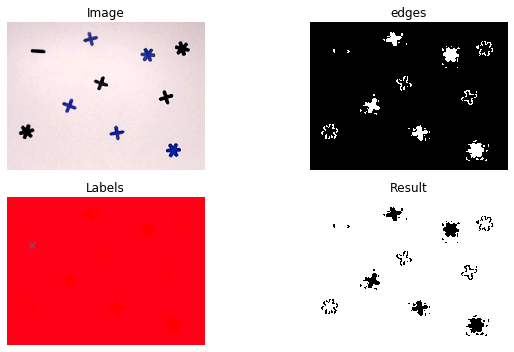

pixels 10944.0


In [26]:
size, labelled = edge_detection_RGB(newim1, 1)
print('pixels', size) #13128.0 index=0 // 294070 index =1 (background)
# -> colored pixels = 13130